# Librerias

In [1]:
from google.colab import drive
import seaborn as sns
import sklearn.metrics as metrics
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from PIL import Image
import pickle
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Model
from scipy.optimize import minimize 
from sklearn.metrics import log_loss
from funciones_auxiliares import *
from probas_calibradas import *

# Importamos data

In [2]:
# cambiar path
path="/content/gdrive/MyDrive/modelosFER2013"

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data=pd.read_csv("/content/gdrive/MyDrive/fer2013.csv")
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [5]:
# Separamos training y public/private testing data
valid_data = data[data.Usage=="PublicTest"].reset_index(drop=True)
test_data = data[data.Usage=="PrivateTest"].reset_index(drop=True)
train_data = data[data.Usage=="Training"].reset_index(drop=True)

# Loading

In [6]:
fer2013_to_X(train_data,"train")
fer2013_to_X(valid_data,"valid")
fer2013_to_X(test_data,"test")

# Modelos

Leaderboard competencia: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard

In [7]:
modelo_logistico=pickle.load(open(f"{path}/ML_final_model.sav", 'rb'))
modelo_fc=tf.keras.models.load_model(f"{path}/FC_final_model.h5")
modelo_cnn=tf.keras.models.load_model(f"{path}/CNN_final_model.h5")
modelo_tl=tf.keras.models.load_model(f"{path}/VGGface_final_model.h5")

In [8]:
img_height, img_width, img_channel = 48,48,1
xy_testing = tf.keras.preprocessing.image_dataset_from_directory("/content/data/test", image_size=(48,48), color_mode='grayscale',label_mode="int")

Found 3589 files belonging to 7 classes.


In [9]:
x_test=[]
y_test=[]
for x, y in xy_testing:
  for im in list(np.array(x)):
    x_test=x_test+[np.array(im)]#a)]
  y_test=y_test+list(np.array(y))

x_test=np.array(x_test).reshape(len(x_test), img_height, img_width, img_channel)
y_test=np.array(y_test)

In [10]:
img_height, img_width, img_channel = 224, 224,3
xy_testing_rgb = tf.keras.preprocessing.image_dataset_from_directory("/content/data/test", image_size=(img_height, img_width), color_mode='rgb',label_mode="int")

Found 3589 files belonging to 7 classes.


In [11]:
x_test_rgb=[]
y_test_rgb=[]

for x, y in xy_testing_rgb:
  for im in list(np.array(x)):
    x_test_rgb=x_test_rgb+[np.array(im)]#a)]
  y_test_rgb=y_test_rgb+list(np.array(y))

x_test_rgb=np.array(x_test_rgb).reshape(len(x_test_rgb), img_height, img_width, img_channel)
y_test_rgb=np.array(y_test_rgb)

In [12]:
img_height, img_width, img_channel = 48,48,1
xy_validation = tf.keras.preprocessing.image_dataset_from_directory("/content/data/valid", image_size=(48,48), color_mode='grayscale',label_mode="int")

Found 3589 files belonging to 7 classes.


In [13]:
x_valid=[]
y_valid=[]
for x, y in xy_validation:
  for im in list(np.array(x)):
    x_valid=x_valid+[np.array(im)]#a)]
  y_valid=y_valid+list(np.array(y))

x_valid=np.array(x_valid).reshape(len(x_valid), img_height, img_width, img_channel)
y_valid=np.array(y_valid)

# Metricas matrices de confusion




### Regresión Logística

In [14]:
y_pred=modelo_logistico.predict(x_test.reshape(len(x_test), 48*48*1))
np.mean(y_pred==y_test)

0.33853441069935913

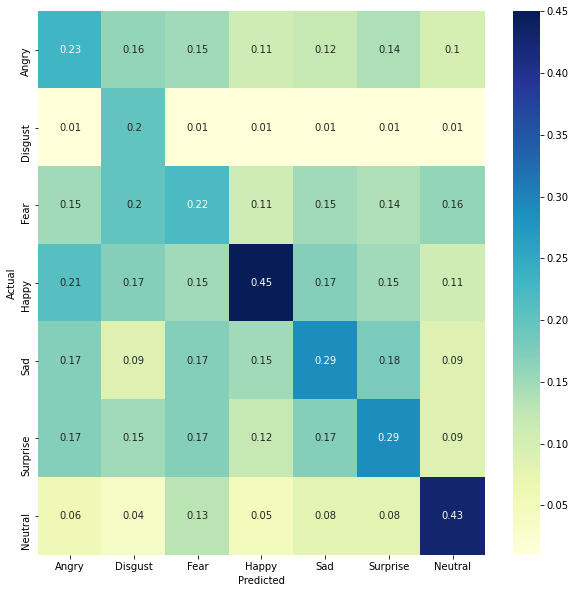

In [15]:
plot_cm(y_test, y_pred)

### Red Fully Connected

In [16]:
test_loss, test_acc = modelo_fc.evaluate(xy_testing, verbose=2)
test_loss, test_acc

113/113 - 4s - loss: 1.5939 - accuracy: 0.3865


(1.593856930732727, 0.3864586353302002)

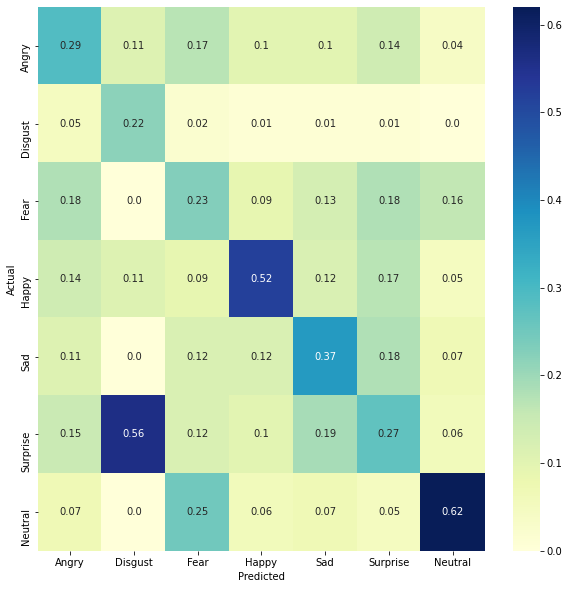

In [17]:
y_pred=modelo_fc.predict(x_test).argmax(axis=1)
plot_cm(y_test, y_pred)

### Red CNN

In [18]:
test_loss, test_acc = modelo_cnn.evaluate(xy_testing, verbose=2)
test_loss, test_acc

113/113 - 30s - loss: 1.2726 - accuracy: 0.6559


(1.2726296186447144, 0.6558930277824402)

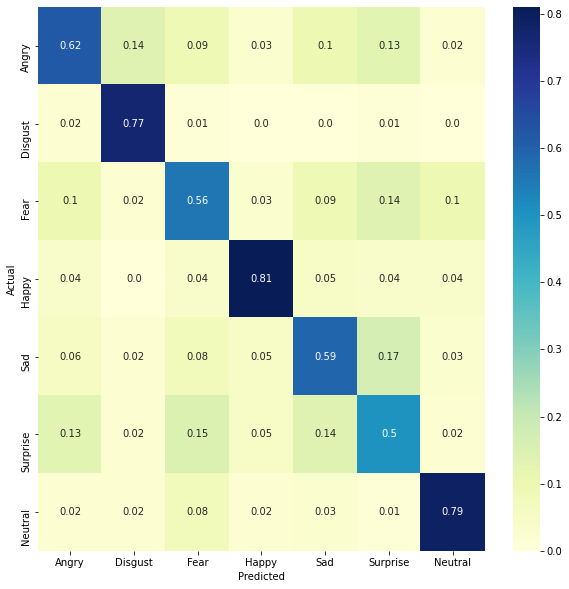

In [19]:
y_pred=modelo_cnn.predict(x_test).argmax(axis=1)
plot_cm(y_test, y_pred)

### Redes preentrenadas

In [20]:
test_loss, test_acc = modelo_tl.evaluate(xy_testing_rgb, verbose=2)
test_loss, test_acc

113/113 - 11s - loss: 1.1528 - accuracy: 0.7208


(1.1527665853500366, 0.7208135724067688)

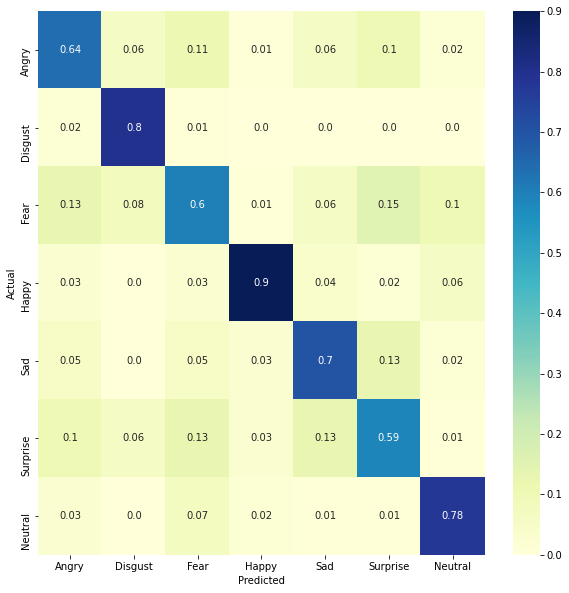

In [21]:
y_pred=modelo_tl.predict(x_test_rgb).argmax(axis=1)
plot_cm(y_test_rgb, y_pred)

# Reliability diagrams

Inspiración: https://github.com/markus93/NN_calibration/blob/master/scripts/calibration/Reliability%20Diagram.ipynb

In [14]:
y_test_rgb
y_pred_tl=modelo_tl.predict(x_test_rgb).argmax(axis=1)
y_confs_tl=modelo_tl.predict(x_test_rgb).max(axis=1)
y_probs_tl=modelo_tl.predict(x_test_rgb)
acc_tl,conf_tl,lon=get_bin_info(y_confs_tl, y_pred_tl, y_test_rgb, bin_size = 0.1)

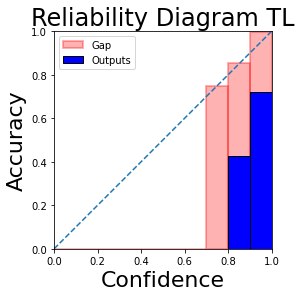

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', sharey='row')
rel_diagram_sub(acc_tl,conf_tl, ax, name = "Reliability Diagram TL",  yname = "Accuracy", xname="Confidence")

In [16]:
y_test
y_pred=modelo_cnn.predict(x_test).argmax(axis=1)
y_confs=modelo_cnn.predict(x_test).max(axis=1)
y_probs=modelo_cnn.predict(x_test)
acc,conf,lon=get_bin_info(y_confs, y_pred, y_test, bin_size = 0.1)

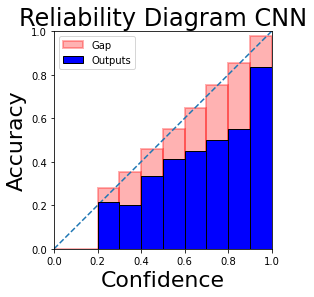

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', sharey='row')
rel_diagram_sub(acc, conf, ax, name = "Reliability Diagram CNN", yname = "Accuracy", xname="Confidence")

# Calibrando CNN

Inspiración: https://stackoverflow.com/questions/62013025/keras-remove-activation-function-of-last-layer

In [18]:
y_probs_ts=probas_calibradas(modelo_cnn,x_valid,x_test,y_valid,input_shape=(48,48,1),numero_clases=7)

In [19]:
y_confs_ts=np.array(y_probs_ts).max(axis=1)
y_pred_ts=np.array(y_probs_ts).argmax(axis=1)

acc_ts,conf_ts,lon=get_bin_info(y_confs_ts, y_pred_ts, y_test, bin_size = 0.1)

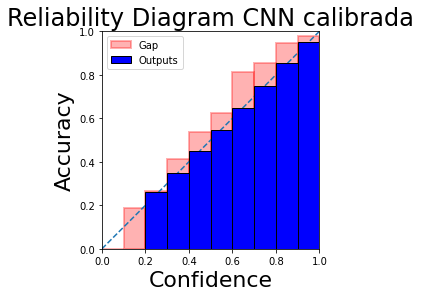

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', sharey='row')
rel_diagram_sub(acc_ts,conf_ts, ax, name = "Reliability Diagram CNN calibrada", yname = "Accuracy", xname="Confidence")

# Exploración expresiones

Inspiración: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

(55, 48, 48, 1)


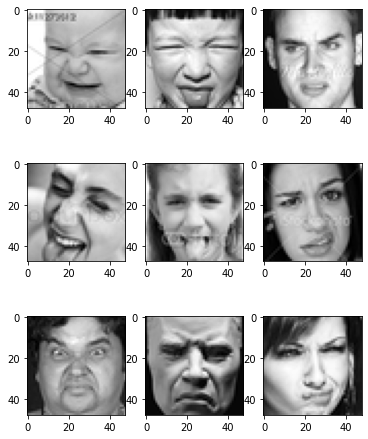

In [21]:
expresiones=x_test[y_test==1]
print(expresiones.shape)
#Data Visualization
fig = plt.figure(figsize=(6,8))
for i in range(1, 10):
    fig.add_subplot(3,3,i)
    plt.imshow(expresiones[i].reshape(48,48),cmap='gray')
    plt.grid(False)

conv2d_4 (3, 3, 1, 64)
conv2d_5 (3, 3, 64, 64)
conv2d_6 (3, 3, 64, 256)
conv2d_7 (3, 3, 256, 256)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 48, 48, 1)]       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________
(1, 48, 48, 1)


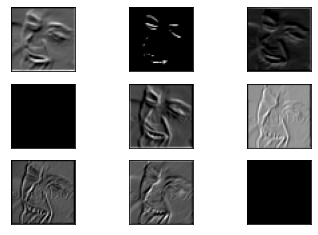

In [22]:
modelo=modelo_cnn
for layer in modelo.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)


num=1
# redefine model to output right after the first hidden layer
model = Model(inputs=modelo.inputs, outputs=modelo.layers[num].output)
model.summary()

# load the image with the required shape
img = expresiones[4]

# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
print(img.shape)
# get feature map for first hidden layer
feature_maps = model.predict(img)

# plot all 64 maps in an 8x8 squares
square = 3
ix = 1
for _ in range(square):
  for _ in range(square):
    # specify subplot and turn of axis
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
		# plot filter channel in grayscale
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1
    
# show the figure
plt.show()